# End-to-End Analysis and Visualization of E3SM Data using nco and xCDAT

E3SM Tutorial Workshop 2024

05/07/2024

Authors: [Stephen Po-Chedley](https://github.com/pochedls) and [Tom Vo](https://github.com/tomvothecoder)


## Overview

This exercise notebook will walkthrough using regridding E3SM data to a
rectilinear grid using `ncremap`, then performing analysis and visualization using xCDAT.

### Sections

1. Prerequisite: Set up the E3SM Unified Environment v1.10.0 Python Kernel
2. Setup Code
3. Use NCO to regrid E3SM data to a rectilinear grid
4. I/O
5. Regridding
6. Spatial Averaging
7. Temporal Computations
8. General Dataset Utilities


## Prerequisite: Set up the E3SM Unified Environment v1.10.0 Python Kernel

_Skip this section if you've already done it_

1. Open a terminal in Jupyter Hub.
2. Run the commands below to add the kernel to NERSC Jupyter Hub.

   ```bash
   source /global/common/software/e3sm/anaconda_envs/load_latest_e3sm_unified_pm-cpu.sh

   python -m ipykernel install \
   --user --name e3sm_unified_1.10.0 --display-name e3sm_unified.1.10.0
   ```

   &mdash; <cite>https://docs.nersc.gov/services/jupyter/how-to-guides/#how-to-use-a-conda-environment-as-a-python-kernel</cite>

3. Refresh this page.
4. Select the kernel for this notebook by clicking the current kernel in the top-right
   (where it says NERSC Python in the screenshot).

   <img src="kernel-instructions-1.png" width=500px/>

5. Select `e3sm_unified.1.10.0` from the list of environments.

   <img src="kernel-instructions-2.png" width=500px/>


## Setup Code


In [8]:
import glob

import numpy as np
from xarray.coding.calendar_ops import _datetime_to_decimal_year as dt2decimal
import xcdat as xc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# The data directory containing the NetCDF files.
data_glob = "/global/cfs/cdirs/e3sm/www/Tutorials/2024/simulations/extendedOutput.v3.LR.historical_0101/archive/atm/hist/*.h0.*.nc"

# The absolute paths to each NetCDF file in the data directory.
data_paths = glob.glob(data_glob)

# The absolute path to the remap file.
remap_file = "/global/cfs/cdirs/e3sm/diagnostics/maps/map_ne30pg2_to_cmip6_180x360_aave.20200201.nc"

## Use NCO to regrid E3SM data to a rectilinear grid


### Now call ncremap to regrid the file to a 0.5 x 0.5 degree grid

Typically a user would call this command directly from the shell or write a batch script to run ncremap on more than one file. Here we will use `glob` to find all the source netcdf files and then regrid `TREFHT` in each file by calling `ncremap` with the `os.system` command. We will output this data into a folder in your current directory called `remapped`.


In [9]:
%%bash
# create output directory
mkdir -p remapped
# source e3sm-unified environment
source /global/common/software/e3sm/anaconda_envs/load_latest_e3sm_unified_pm-cpu.sh
# do regridding
# format: ncremap -m REMAPFILE.nc -t 1 -v VAR_OF_INTEREST /PATH/TO/DATA/*nc
ncremap -m /global/cfs/cdirs/e3sm/diagnostics/maps/map_ne30pg2_to_cmip6_180x360_aave.20200201.nc -t 1 -v TREFHT /global/cfs/cdirs/e3sm/www/Tutorials/2024/simulations/extendedOutput.v3.LR.historical_0101/archive/atm/hist/extendedOutput.v3.LR.historical_0101.eam.h0.*nc >/dev/null 2>&1
# move output to remapped directory
mv extendedOutput.v3.LR.historical_0101.eam.h0.*nc remapped/

## I/O


### Now let's load in the regridded data and use xcdat to perform additional calculations on the 0.5 x 0.5 degree grid

We will use `xc.open_mfdataset` to open all the remapped netcdf files in a single `xr.dataset` object. With xcdat, you can specify the directory `remapped` and xcdat will read in all netcdf files as one `xr.dataset` object. You could also use `ds = xr.open_mfdataset('remapped/*.nc')`.


In [111]:
ds = xc.open_mfdataset("remapped")
ds

/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.3_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.3_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnd: 2, time: 180)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 2000-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    gw         (lat) float64 dask.array<chunksize=(180,), meta=np.ndarray>
    area       (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    TREFHT     (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/25)
    ne:                30
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         399d430113
    product:           model-output
    ...                ...
    remap_script:      ncremap
    remap_hostname:    login16
    remap_version:     5.2.2
    NCO:               netCDF Operators version 5.2.2 (Homepage = http://nco....
    map_file:          /global/cfs/cdirs/e3sm/diagnostics/maps/map_ne30pg2_to...
    input_file:        /global/cfs/cdirs/e3sm/www/Tutorials/2024/simulations/...

...but checkout the time coordinate:


In [113]:
ds.time.values[0:3]

array([cftime.DatetimeNoLeap(2000, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 4, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

The monthly time coordinates begin in 2/2000, even though our first file is for 1/2000. This is because E3SM saves out monthly history at midnight at the end of the month. xCDAT can handle this by centering the time coordinates between the monthly time bounds (using `center_times=True`):


In [116]:
ds = xc.open_mfdataset("remapped", center_times=True)

/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.3_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.3_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


## Regridding with xCDAT

We often want to regrid a dataset to a new grid to facilitate data analysis or comparisons with other datasets. The current dataset is at 0.5 x 0.5<sup>o</sup> resolution, so we'll start be remapping it to a 2.5 x 2.5<sup>o</sup> grid.


### First, we specify the target grid


In [117]:
# create target axes
nlat, nlat_bnds = xc.create_axis(
    "lat", np.arange(-88.75, 90, 2.5), attrs={"units": "degrees_north", "axis": "Y"}
)
nlon, nlon_bnds = xc.create_axis(
    "lon", np.arange(1.25, 360, 2.5), attrs={"units": "degrees_east", "axis": "X"}
)
# use the target axes to create the target grid
ngrid = xc.create_grid(x=(nlon, nlon_bnds), y=(nlat, nlat_bnds))

### Call the xESMF regridder

Here we're using bilinear regridding, but other methods may be appropriate (e.g., you may want to use "conservative_normed" for fields that should be conserved globally).


#### 💻 Your turn:

Regrid "TREFHT" with the `ngrid` created above using `xesmf` and `bilinear`.

- API Documentation: https://xcdat.readthedocs.io/en/stable/generated/xarray.Dataset.regridder.horizontal.html


In [ ]:
# Starter code here. When ready, click on the three dots below for the solution.
# ds_xesmf = ds.

In [7]:
ds_xesmf = ds.regridder.horizontal("TREFHT", ngrid, tool="xesmf", method="bilinear")

NameError: name 'ds' is not defined

### Compare the results (for the first timestep)

Now we just plot the results for comparison.


Text(0.5, 1.0, 'xESMF 2.5$^{\\circ}$ x 2.5$^{\\circ}$')

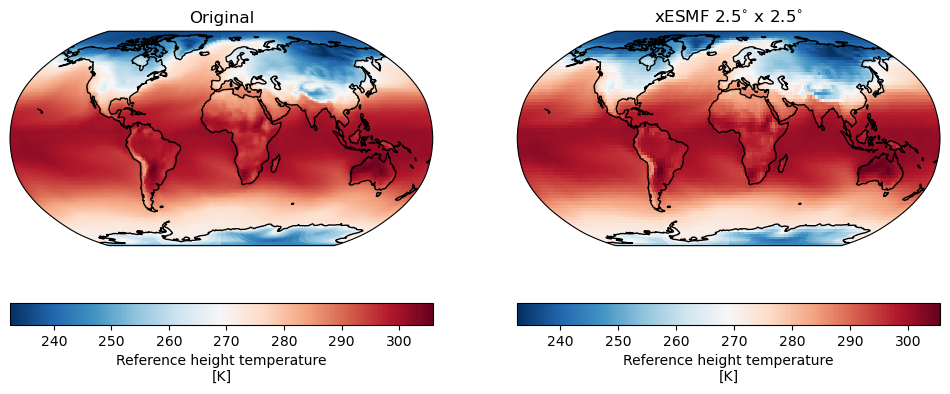

In [119]:
map_proj = ccrs.Robinson()

# plot original data (first time step)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1, projection=map_proj)
p = ds.TREFHT[0].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    subplot_kws={"projection": map_proj},
    cbar_kwargs={"orientation": "horizontal"},
    cmap=plt.cm.RdBu_r,
)
ax = plt.gca()
ax.coastlines()
plt.title("Original")

# plot the remapped data (first time step)
plt.subplot(1, 2, 2, projection=map_proj)
p = ds_xesmf.TREFHT[0].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    subplot_kws={"projection": map_proj},
    cbar_kwargs={"orientation": "horizontal"},
    cmap=plt.cm.RdBu_r,
)
ax = plt.gca()
ax.coastlines()
plt.title("xESMF 2.5$^{\circ}$ x 2.5$^{\circ}$")

### Vertical Regridding

xcdat can also regrid in the vertical. Here we'll grab some 3D temperature data and regrid it in the vertical. First, we need to remap some 3-dimensional data.


In [120]:
%%bash
# source e3sm-unified environment
source /global/common/software/e3sm/anaconda_envs/load_latest_e3sm_unified_pm-cpu.sh
# remap (we are only remapping one file and specifying the output location)
ncremap -m /global/cfs/cdirs/e3sm/diagnostics/maps/map_ne30pg2_to_cmip6_180x360_aave.20200201.nc -t 1 -v T /global/cfs/cdirs/e3sm/www/Tutorials/2024/simulations/extendedOutput.v3.LR.historical_0101/archive/atm/hist/extendedOutput.v3.LR.historical_0101.eam.h0.2000-01.nc T_extendedOutput.v3.LR.historical_0101.eam.h0.2000-01.nc >/dev/null 2>&1

Now let's load the data:


In [121]:
fn = glob.glob("extendedOutput.v3.LR.historical_0101.eam.h0.2000-01.nc")[
    0
]  # get one file
fnr = "T_" + fn.split("/")[-1]  # new file name

# load regridded data
ds3d = xc.open_dataset(fnr)

Next, we will do the vertical remapping...


In [122]:
# first construct the 3D pressure field
pressure = ds3d["hyam"] * 1000.0 + ds3d["hybm"] * ds3d["PS"]

# next, construct the target pressure axis
target_plevs = [
    100000,
    92500,
    85000,
    75000,
    70000,
    60000,
    50000,
    40000,
    30000,
    25000,
    20000,
    15000,
    10000,
    7000,
    5000,
    3000,
    1000,
    500,
    300,
    100,
]
nplev = xc.create_grid(z=xc.create_axis("lev", target_plevs))

# do vertical regrid
dsvr = ds3d.regridder.vertical("T", nplev, method="log", target_data=pressure)

/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.3_login/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


Finally, we plot the result:


/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.3_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


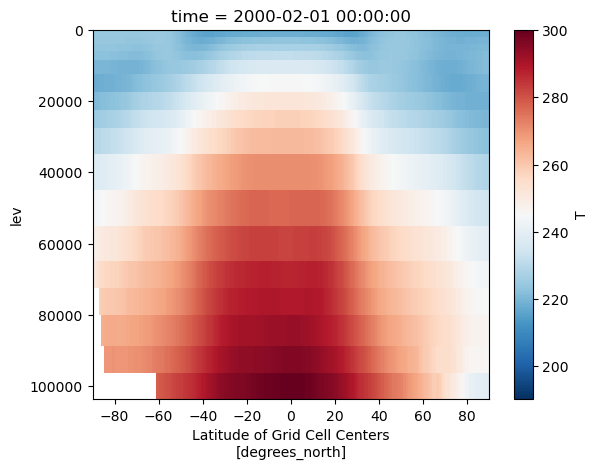

In [123]:
# plot result
dsvr_zonal = dsvr.spatial.average("T", axis=["X"]).squeeze()
dsvr_zonal.T.plot(cmap=plt.cm.RdBu_r)
plt.gca().invert_yaxis()

## Spatial Averaging with xCDAT

Area-weighted spatial averaging is a common technique to reduce dimensionality in geospatial datasets. xCDAT can perform this calculation over full domains or regions of interest.


#### 💻 Your turn:

Calculate the spatial average of "TREFHT" and store the results in a Python variable.

- API Documentation: https://xcdat.readthedocs.io/en/stable/generated/xarray.Dataset.spatial.average.html


In [ ]:
# Your code here. When ready, click on the three dots below for the solution.
# ds_global =

In [ ]:
ds_global = ds.spatial.average("TREFHT")

#### Now let's plot the results.

Note that the spatial averager returns a dataset object so we still need to specify "TREFHT"
to plot the dataarray.


/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.3_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.3_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Text(0, 0.5, 'Global Mean Temperature [K]')

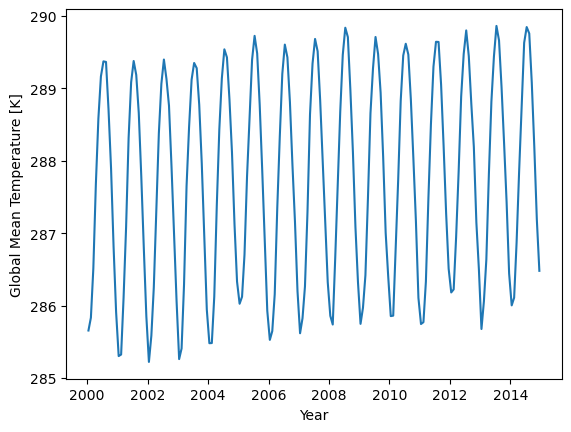

In [125]:
dtime = dt2decimal(ds_global.time)  # decimal time
plt.plot(dtime, ds_global["TREFHT"].values)
plt.xlabel("Year")
plt.ylabel("Global Mean Temperature [K]")

Above, we did not specify any constraints. So xCDAT calculated the domain (global) average. Users can also specify their own bounds.


#### 💻 Your turn:

Calculate the the average surface temperature ("TREFHT") in the Niño 3.4 region.

- API Documentation: https://xcdat.readthedocs.io/en/stable/generated/xarray.Dataset.spatial.average.html
- Hint: Pass latitude bounds of (-5, 5) and longitude bounds of (190, 240) and keep the weights.


In [5]:
# Starter code here. When ready, click on the three dots below for the solution.
# ds_nino34 = ds_xesmf.spatial.average()

In [6]:
ds_nino34 = ds_xesmf.spatial.average(
    "TREFHT", lat_bounds=(-5, 5), lon_bounds=(190, 240), keep_weights=True
).load()

NameError: name 'ds_xesmf' is not defined

In this case, we specified `keep_weights=True`. The weights provide full spatial weighting for grid cells entirely within the Niño 3.4 region. If a grid cell is partially in the Niño 3.4 region, it received partial weight (note we use the 2 x 2 degree grid in this example to show the partial weights and to speed up plotting). Note that you can also supply your own weights (note that you can't automatically subset with `lat_bounds` and `lon_bounds` if you supply your own weights).


Text(0.5, 1.0, 'Nino 3.4 Weights')

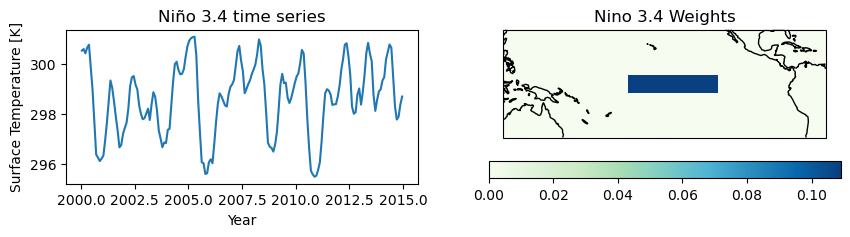

In [127]:
# show the nino 3.4 time series
plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.plot(dtime, ds_nino34["TREFHT"].values)
plt.xlabel("Year")
plt.ylabel("Surface Temperature [K]")
plt.title("Niño 3.4 time series")

# show the weights
map_proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.subplot(1, 2, 2, projection=map_proj)
plt.pcolor(
    ds_nino34.lon,
    ds_nino34.lat,
    ds_nino34.lat_lon_wts.T,
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.GnBu,
)
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(orientation="horizontal")
plt.title("Nino 3.4 Weights")

## Temporal Computations with xCDAT

In the examples below, we will performing temporal computations on the `xarray.Dataset` object using xCDAT.


### Annual cycle

In the global mean time series above, there are large seasonal swings in global temperature. Here we compute the seasonal mean climatology.


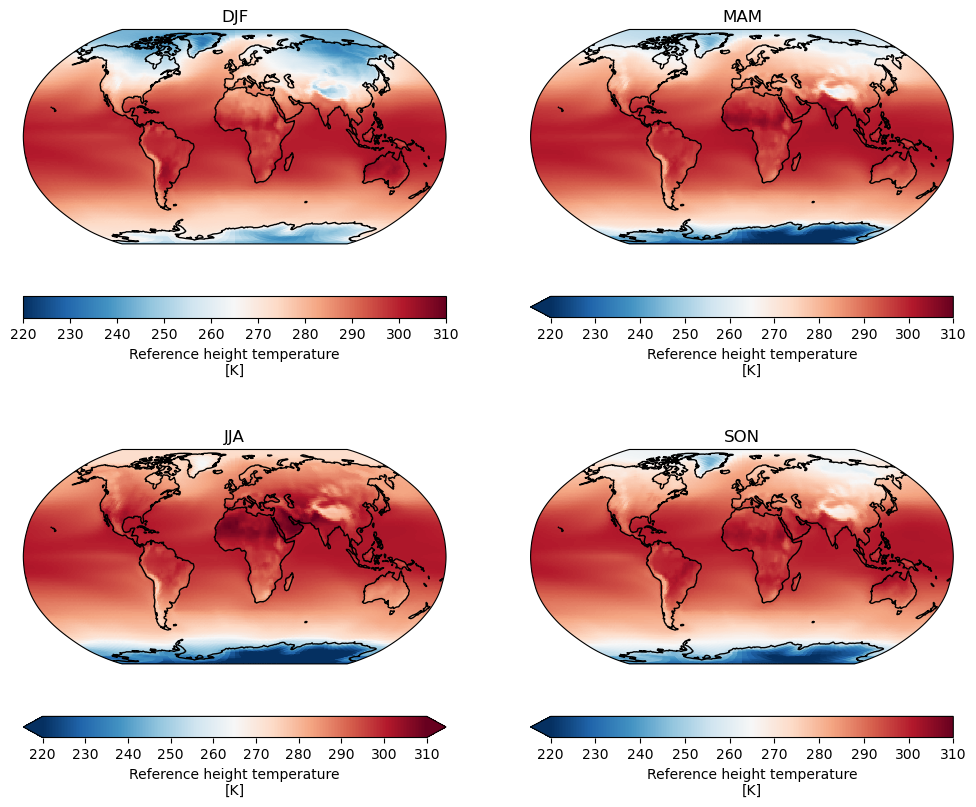

In [128]:
# compute the climatology
ds_clim = ds.temporal.climatology("TREFHT", freq="season")

# plot the seasonal means
map_proj = ccrs.Robinson()
titles = ["DJF", "MAM", "JJA", "SON"]
plt.figure(figsize=(12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1, projection=map_proj)
    p = ds_clim.TREFHT[i].plot(
        transform=ccrs.PlateCarree(),
        subplot_kws={"projection": map_proj},
        cbar_kwargs={"orientation": "horizontal"},
        cmap=plt.cm.RdBu_r,
        vmin=220,
        vmax=310,
    )
    ax = plt.gca()
    ax.coastlines()
    plt.title(titles[i])

### Departures

It can also be useful to show the departures from the climatological average. Here we show an example of this. In this case, `xcdat` will operate on the global mean time series we calculated above. Note that you can set the climatological reference period (e.g., with `reference_period=("1950-01-01", "1999-12-31")` for historical era departures).


/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.3_login/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]


Text(0, 0.5, 'Global Mean Surface Temperature Anomaly [K]')

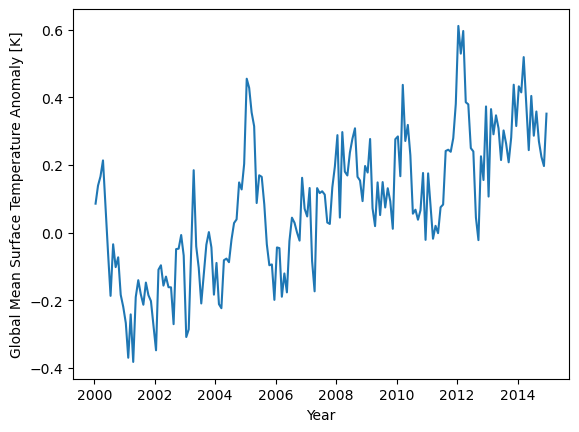

In [129]:
ds_global_anomaly = ds_global.temporal.departures(
    "TREFHT", freq="month", reference_period=("2000-01-01", "2009-12-31")
)
plt.plot(dtime, ds_global_anomaly.TREFHT.values)
plt.xlabel("Year")
plt.ylabel("Global Mean Surface Temperature Anomaly [K]")

### Group averages

`xcdat` also allows you to calculate group averages (e.g., annual or seasonal mean from monthly data or monthly mean from daily data). Here we show the computation of annual departures from the time series above.


/global/common/software/e3sm/anaconda_envs/base/envs/e3sm_unified_1.9.3_login/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Text(0, 0.5, 'Global Mean Surface Temperature [K]')

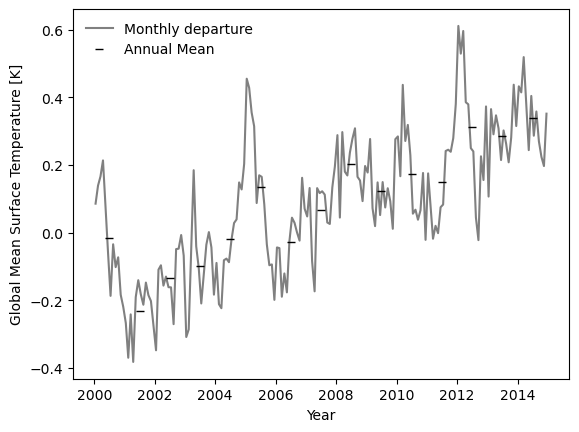

In [130]:
# compute annual mean from anomaly time series
ds_global_anomaly_annual = ds_global_anomaly.temporal.group_average(
    "TREFHT", freq="year"
)

# plot data
dtime_annual = dt2decimal(ds_global_anomaly_annual.time) + 0.5
plt.plot(
    dtime, ds_global_anomaly.TREFHT.values, label="Monthly departure", color="gray"
)
plt.plot(
    dtime_annual,
    ds_global_anomaly_annual.TREFHT.values,
    color="k",
    linestyle="",
    marker="_",
    label="Annual Mean",
)
plt.legend(frameon=False)
plt.xlabel("Year")
plt.ylabel("Global Mean Surface Temperature [K]")

## General Dataset Utilities

xCDAT includes various utilities for data manipulation, including
reorientation of the longitude axis, centering of time coordinates using time bounds, and adding and getting bounds.


### Reorient the longitude axis

Longitude can be represented from 0 to 360 E or as 180 W to 180 E. xcdat allows you to convert between these axes systems.


In [131]:
ds.lon

<xarray.DataArray 'lon' (lon: 360)>
array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    long_name:      Longitude of Grid Cell Centers
    standard_name:  longitude
    units:          degrees_east
    axis:           X
    valid_min:      0.0
    valid_max:      360.0
    bounds:         lon_bnds

In [132]:
ds2 = xc.swap_lon_axis(ds, to=(-180, 180))
ds2.lon

<xarray.DataArray 'lon' (lon: 360)>
array([-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:      Longitude of Grid Cell Centers
    standard_name:  longitude
    units:          degrees_east
    axis:           X
    valid_min:      0.0
    valid_max:      360.0
    bounds:         lon_bnds

### Add missing bounds

Bounds are critical to many `xcdat` operations. For example, they are used in determining the weights in spatial or temporal averages and in regridding operations. `add_missing_bounds()` will attempt to produce bounds if they do not exist in the original dataset.


In [133]:
# We are dropping the existing bounds to demonstrate adding bounds.
ds4 = ds.drop_vars("time_bnds")

In [134]:
try:
    ds4.bounds.get_bounds("T")
except KeyError as e:
    print(e)

"No bounds data variables were found for the 'T' axis. Make sure the dataset has bound data vars and their names match the 'bounds' attributes found on their related time coordinate variables. Alternatively, you can add bounds with `ds.bounds.add_missing_bounds()` or `ds.bounds.add_bounds()`."


In [135]:
ds5 = ds4.bounds.add_missing_bounds(axes=["T"])